In [1]:
try:
    import google.colab
    USE_COLAB = True
except:
    USE_COLAB = False

if USE_COLAB:
    print("Don't forget to avoid disconnections:")
    print("""
    function ClickConnect(){
        console.log("Clicking"); 
        document.querySelector("colab-connect-button").click() 
    }
    setInterval(ClickConnect,60000)
    
    """)

In [2]:
import sys
if 'google.colab' in sys.modules:
    import os

    os.system('apt-get install -y xvfb')
    os.system('wget https://raw.githubusercontent.com/yandexdataschool/Practical_DL/fall18/xvfb -O ../xvfb')
    os.system('apt-get install -y python-opengl ffmpeg')
    os.system('pip install pyglet==1.2.4')
    os.system('pip install gym')

    prefix = 'https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/week09_policy_II/'

    os.system('wget ' + prefix + 'runners.py')
    os.system('wget ' + prefix + 'mujoco_wrappers.py')

    print('setup complete')

# XVFB will be launched if you run on a server
import os
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !bash ../xvfb start
    os.environ['DISPLAY'] = ':1'

bash: ../xvfb: No such file or directory


# Implementing Proximal Policy Optimization 


In this notebook you will be implementing Proximal Policy Optimization algorithm, 
scaled up version of which was used to train [OpenAI Five](https://openai.com/blog/openai-five/) 
to [win](https://openai.com/blog/how-to-train-your-openai-five/) against the
world champions in Dota 2.
You will be solving a continuous control environment on which it may be easier and faster 
to train an agent, however note that PPO here may not be the best algorithm as, for example,
Deep Deterministic Policy Gradient and Soft Actor Critic may be more suited 
for continuous control environments. To run the environment you will need to install 
[pybullet-gym](https://github.com/benelot/pybullet-gym) which unlike MuJoCo 
does not require you to have a license.

To install the library:

In [3]:
# !git clone https://github.com/benelot/pybullet-gym lib/pybullet-gym
# !pip install -e lib/pybullet-gym

The overall structure of the code is similar to the one in the A2C optional homework, but don't worry if you haven't done it, it should be relatively easy to figure it out. 
First, we will create an instance of the environment. 
We will normalize the observations and rewards, but before that you will need a wrapper that will 
write summaries, mainly, the total reward during an episode. You can either use one for `TensorFlow` 
implemented in `atari_wrappers.py` file from the optional A2C homework, or implement your own. 

In [4]:
import numpy as np
from tqdm import trange
from torch.autograd import Variable
from IPython.display import clear_output
import matplotlib.pyplot as plt
from pandas import DataFrame
from torch.distributions import MultivariateNormal

In [5]:
import gym 
import pybulletgym

env = gym.make("HalfCheetahMuJoCoEnv-v0")
print("observation space: ", env.observation_space,
      "\nobservations:", env.reset())
print("action space: ", env.action_space, 
      "\naction_sample: ", env.action_space.sample())

current_dir=/Users/alex-kozinov/opt/anaconda3/lib/python3.6/site-packages/pybullet_envs/bullet
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WalkerBase::__init__
options= 
observation space:  Box(17,) 
observations: [ 0.0194237  -0.01371595  0.02267135  0.07935468  0.08586212  0.02884284
  0.01284848  0.08143667  0.          0.          0.          0.
  0.          0.          0.          0.          0.        ]
action space:  Box(6,) 
action_sample:  [ 0.09762701  0.43037874  0.20552675  0.08976637 -0.1526904   0.29178822]


/Users/alex-kozinov/opt/anaconda3/lib/python3.6/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


In [6]:
from collections import defaultdict, deque
class SummariesBase(gym.Wrapper):
    """ Env summaries writer base."""

    def __init__(self, env, prefix=None, running_mean_size=100):
        super().__init__(env)
        self.episode_counter = 0
        self.prefix = prefix or self.env.spec.id

        nenvs = getattr(self.env.unwrapped, "nenvs", 1)
        self.rewards = np.zeros(nenvs)
        self.had_ended_episodes = np.zeros(nenvs, dtype=np.bool)
        self.episode_lengths = np.zeros(nenvs)
        self.reward_queues = [deque([], maxlen=running_mean_size)
                              for _ in range(nenvs)]

    def should_write_summaries(self):
        """ Returns true if it's time to write summaries. """
        return np.all(self.had_ended_episodes)

    def add_summaries(self):
        """ Writes summaries. """
        self.add_summary_scalar(
            f"{self.prefix}/total_reward",
            np.mean([q[-1] for q in self.reward_queues]))
        self.add_summary_scalar(
            f"{self.prefix}/reward_mean_{self.reward_queues[0].maxlen}",
            np.mean([np.mean(q) for q in self.reward_queues]))
        self.add_summary_scalar(
            f"{self.prefix}/episode_length",
            np.mean(self.episode_lengths))
        if self.had_ended_episodes.size > 1:
            self.add_summary_scalar(
                f"{self.prefix}/min_reward",
                min(q[-1] for q in self.reward_queues))
            self.add_summary_scalar(
                f"{self.prefix}/max_reward",
                max(q[-1] for q in self.reward_queues))
        self.episode_lengths.fill(0)
        self.had_ended_episodes.fill(False)

    def step(self, action):
        obs, rew, done, info = self.env.step(action)
        self.rewards += rew
        self.episode_lengths[~self.had_ended_episodes] += 1

        info_collection = [info] if isinstance(info, dict) else info
        done_collection = [done] if isinstance(done, bool) else done
        done_indices = [i for i, info in enumerate(info_collection)
                        if info.get("real_done", done_collection[i])]
        for i in done_indices:
            if not self.had_ended_episodes[i]:
                self.had_ended_episodes[i] = True
            self.reward_queues[i].append(self.rewards[i])
            self.rewards[i] = 0

        if self.should_write_summaries():
            self.add_summaries()
        return obs, rew, done, info

    def reset(self, **kwargs):
        self.rewards.fill(0)
        self.episode_lengths.fill(0)
        self.had_ended_episodes.fill(False)
        return self.env.reset(**kwargs)


class Summaries(SummariesBase):
    _summaries = defaultdict(list)
    _summary_step = None

    @classmethod
    def set_step(cls, step):
        cls._summary_step = step

    @classmethod
    def get_values(cls, name):
        return cls._summaries[name]

    @classmethod
    def clear(cls):
        cls._summaries = defaultdict(list)

    def __init__(self, env, prefix = None, running_mean_size = 100):
        super().__init__(env, prefix, running_mean_size)

    def add_summary_scalar(self, name, value):
        self._summaries[name].append((self._summary_step, value))

In [7]:
# ### REMOVE THIS

# class Summaries(gym.Wrapper):
#     """ Wrapper to write summaries. """
#     def __init__(self, env):
#         super().__init__(env)
#         self.current_reward = 0
#         self.reward_last_session = 0

#     def step(self, action):

#         obs, reward, done, info = self.env.step(action)
#         self.current_reward += reward

#         if done:
#             self.reward_last_session = self.current_reward
#             self.current_reward = 0

#         return obs, reward, done, info
  
#     def reset(self, **kwargs):
#         self.current_reward = 0
#         return self.env.reset(**kwargs)

The normalization wrapper will subtract running mean from observations and rewards and divide 
the resulting quantities by the  running variances.

In [8]:
from mujoco_wrappers import Normalize

env = Normalize(Summaries(gym.make("HalfCheetahMuJoCoEnv-v0")));
env.unwrapped.seed(0);

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WalkerBase::__init__


Next, you will need to define a model for training. We suggest that you use two separate networks: one for policy
and another for value function. Each network should be a 3-layer MLP with 64 hidden units, $\mathrm{tanh}$ 
activation function, kernel matrices initialized with orthogonal initializer with parameter $\sqrt{2}$
and biases initialized with zeros. 

Our policy distribution is going to be multivariate normal with diagonal covariance. 
The network from above will predict the mean, and the covariance should be represented by a single 
(learned) vector of size 6 (corresponding to the dimensionality of the action space from above). 
You should initialize this vector to zero and take the exponent of it to always
have a non-negative quantity. 

Overall the model should return three things: predicted mean of the distribution, variance vector, 
value function. 

In [9]:
# import tensorflow as tf
import torch
from torch import nn

def init_weights(m):
    if type(m) in (nn.Linear, nn.Conv2d):
        nn.init.orthogonal_(m.weight.data, np.sqrt(float(2)))
        if m.bias is not None:
            m.bias.data.fill_(0)

def get_body_network(layers_size):
    layers = []
    for in_size, out_size in zip(layers_size[:-1], layers_size[1:]):
        layers.append(nn.Linear(in_size, out_size))
        layers.append(nn.Tanh())
    return nn.Sequential(*layers)


class PPOAgent(nn.Module):
    def __init__(self, state_shape, n_actions, hidden_size=[64, 64, 64]):
        '''
        Here you should define your model
        You should have LOG-PROBABILITIES as output because you will need it to compute loss
        We recommend that you start simple: 
        use 1-2 hidden layers with 100-500 units and relu for the first try
        '''
        super(PPOAgent, self).__init__()
        
        layers_size = [state_shape[0]] + hidden_size
        
        self.policy_body = get_body_network(layers_size).apply(init_weights)
        self.mu_head = nn.Linear(hidden_size[-1], n_actions).apply(init_weights)
        self.log_std_head = nn.Parameter(torch.zeros(n_actions))
        
        self.value_body = get_body_network(layers_size).apply(init_weights)
        self.value_head = nn.Linear(hidden_size[-1], 1).apply(init_weights)

    def forward(self, states):
        states = states.float()
        policy_features = self.policy_body(states)
        value_features = self.value_body(states)
        
        mu = self.mu_head(policy_features)
        log_std = self.log_std_head
        std = torch.exp(log_std)
        
        value = self.value_head(value_features)
        
        return mu, std, value

In [10]:
# # REMOVE THIS 

# # import tensorflow as tf
# import torch
# from torch import nn

# def init_weights(m):
#     if type(m) in (nn.Linear, nn.Conv2d):
#         nn.init.orthogonal_(m.weight.data, np.sqrt(float(2)))
#         if m.bias is not None:
#             m.bias.data.fill_(0)

# def get_body_network(layers_size):
#     layers = []
#     for in_size, out_size in zip(layers_size[:-1], layers_size[1:]):
#         layers.append(nn.Linear(in_size, out_size))
#         layers.append(nn.Tanh())
#     return nn.Sequential(*layers)


# class PPOAgent(nn.Module):
#     def __init__(self, hidden_size=[64, 64, 64]):
#         '''
#         Here you should define your model
#         You should have LOG-PROBABILITIES as output because you will need it to compute loss
#         We recommend that you start simple: 
#         use 1-2 hidden layers with 100-500 units and relu for the first try
#         '''
#         super(PPOAgent, self).__init__()
#         state_shape = env.observation_space.shape
#         n_actions = env.action_space.shape[0]
#         layers_size = [state_shape[0]] + hidden_size
        
#         self.policy_body = get_body_network(layers_size).apply(init_weights)
#         self.mu_head = nn.Linear(hidden_size[-1], n_actions).apply(init_weights)
#         self.log_std_head = nn.Parameter(torch.zeros(n_actions))
        
#         self.value_body = get_body_network(layers_size).apply(init_weights)
#         self.value_head = nn.Linear(hidden_size[-1], 1).apply(init_weights)

#     def forward(self, states):
#         states = states.float()
#         policy_features = self.policy_body(states)
#         value_features = self.value_body(states)
        
#         mu = self.mu_head(policy_features)
#         log_std = self.log_std_head
#         std = torch.exp(log_std)
        
#         value = self.value_head(value_features)
        
#         return mu, std, value

This model will be wrapped by a `Policy`. The policy can work in two modes, but in either case 
it is going to return dictionary with string-type keys. The first mode is when the policy is 
used to sample actions for a trajectory which will later be used for training. In this case 
the flag `training` passed to `act` method is `False` and the method should return 
a `dict` with the following keys: 

* `"actions"`: actions to pass to the environment
* `"log_probs"`: log-probabilities of sampled actions
* `"values"`: value function $V^\pi(s)$ predictions.

We don't need to use the values under these keys for training, so all of them should be of type `np.ndarray`.

When `training` is `True`, the model is training on a given batch of observations. In this
case it should return a `dict` with the following keys

* `"distribution"`: an instance of multivariate normal distribution (`torch.distributions.MultivariateNormal` or `tf.distributions.MultivariateNormalDiag`)
* `"values"`: value function $V^\pi(s)$ prediction.

The distinction about the modes comes into play depending on where the policy is used: if it is called from `EnvRunner`, 
the `training` flag is `False`, if it is called from `PPO`, the `training` flag is `True`. These classed 
will be described below. 

In [11]:
from torch.distributions.multivariate_normal import MultivariateNormal


class Policy:
    def __init__(self, model):
        self.model = model
    
    def act(self, inputs, training=False):
        inputs = Variable(torch.FloatTensor(inputs))
        if training:
            mean, scale, values = self.model(inputs)
        else:
            with torch.no_grad():
                mean, scale, values = self.model(inputs)

        distribution = MultivariateNormal(mean, torch.diag(scale))

        if training:
            return {
                "distribution" : distribution,
                "values" : values
            }
        else:
            actions = distribution.sample()
            log_probs = distribution.log_prob(actions)

            return {
                "actions" : actions.numpy(),
                "log_probs" : log_probs.numpy(),
                "values" : values.numpy()
            }

We will use `EnvRunner` to perform interactions with an environment with a policy for a fixed number of timesteps. Calling `.get_next()` on a runner will return a trajectory &mdash; dictionary 
containing keys

* `"observations"`
* `"rewards"` 
* `"resets"`
* `"actions"`
* all other keys that you defined in `Policy`,

under each of these keys there is a `np.ndarray` of specified length $T$ &mdash; the size of partial trajectory. 

Additionally, before returning a trajectory this runner can apply a list of transformations. 
Each transformation is simply a callable that should modify passed trajectory in-place.

In [12]:
class AsArray:
    """ 
    Converts lists of interactions to ndarray.
    """
    def __call__(self, trajectory):
        # Modify trajectory inplace. 
        for k, v in filter(lambda kv: kv[0] != "state", trajectory.items()):
            trajectory[k] = np.asarray(v)

In [13]:
import numpy as np
from runners import EnvRunner

class DummyPolicy:
    def act(self, inputs, training=False):
        assert not training
        return {"actions": np.random.randn(6), "values": np.nan}


runner = EnvRunner(env, DummyPolicy(), 3,
                   transforms=[AsArray()])
trajectory = runner.get_next()

{k: v.shape for k, v in trajectory.items() if k != "state"}

options= 


{'actions': (3, 6),
 'values': (3,),
 'observations': (3, 17),
 'rewards': (3,),
 'resets': (3,)}

You will need to implement the following two transformations. 

The first is `GAE` that implements [Generalized Advantage Estimator](https://arxiv.org/abs/1506.02438).
In it you should add two keys to the trajectory: `"advantages"` and `"value_targets"`. In GAE the advantages
$A_t^{\mathrm{GAE}(\gamma,\lambda)}$ are essentially defined as the exponential 
moving average with parameter $\lambda$ of the regular advantages 
$\hat{A}^{(n)}(s_t) = \sum_{l=0}^{T-1} \gamma^l r_{t+l} + \gamma^{T} V^\pi(s_{t+l}) - V^\pi(s_t)$. 
The exact formula for the computation is the following

$$
A_t^{\mathrm{GAE}(\gamma,\lambda)} = \sum_{l=0}^{T-1} (\gamma\lambda)^l\delta_{t + l}^V,
$$
where $\delta_{t+l}^V = r_{t+l} + \gamma V^\pi(s_{t+l+1}) - V^\pi(s_{t+l})$. You can look at the 
derivation (formulas 11-16) in the paper. Don't forget to reset the summation on terminal
states as determined by the flags `trajectory["resets"]`. You can use `trajectory["values"]`
to get values of all observations except the most recent which is stored under 
 `trajectory["state"]["latest_observation"]`. For this observation you will need to call the policy 
 to get the value prediction.

Once you computed the advantages, you can get the targets for training the value function by adding 
back values:
$$
\hat{V}(s_{t+l}) = A_{t+l}^{\mathrm{GAE}(\gamma,\lambda)} + V(s_{t + l}),
$$
where $\hat{V}$ is a tensor of value targets that are used to train the value function. 

In [14]:
class GAE:
    """ Generalized Advantage Estimator. """
    def __init__(self, policy, gamma=0.99, lambda_=0.95):
        self.policy = policy
        self.gamma = gamma
        self.lambda_ = lambda_
    
    def __call__(self, trajectory):
        resets = trajectory["resets"]
        values = trajectory["values"]
        rewards = trajectory["rewards"]
        last_observation = trajectory["state"]["latest_observation"]
        T = len(resets)
        curr_value = self.policy.act(last_observation, training=False)["values"]
        curr_advantage = 0
        
        advantages = []
        value_targets = []
        for i in reversed(range(T)):
            if resets[i]:
                curr_value = 0
                curr_advantage = 0
            
            delta = rewards[i] + curr_value*self.gamma - values[i]
            curr_advantage = delta + curr_advantage*self.gamma*self.lambda_
            
            advantages.append(curr_advantage)
            curr_value = values[i]
            
        trajectory['advantages'] = np.concatenate(advantages[::-1])
        trajectory['value_targets'] = trajectory['advantages'] + values.squeeze(1)
        return trajectory

The main advantage of PPO over simpler policy based methods like A2C is that it is possible
to train on the same trajectory for multiple gradient steps. The following class wraps 
an `EnvRunner`. It should call the runner to get a trajectory, then return minibatches 
from it for a number of epochs, shuffling the data before each epoch.

In [15]:
class TrajectorySampler:
    """ Samples minibatches from trajectory for a number of epochs. """
    def __init__(self, runner, num_epochs, num_minibatches, transforms=None):
        self.runner = runner
        self.num_epochs = num_epochs
        self.num_minibatches = num_minibatches
        self.transforms = transforms or []
        self.minibatch_count = 0
        self.epoch_count = 0
        self.shuffle_trajectory(resample=True)
    
    def shuffle_trajectory(self, resample=False):
        """ Shuffles all elements in trajectory.
        Should be called at the beginning of each epoch.
        """
        if resample:
            self.trajectory = self.runner.get_next()
            
        self.num_runner_steps = list(self.trajectory.values())[0].shape[0]
        indxs = np.arange(self.num_runner_steps)
        np.random.shuffle(indxs)
        for k, v in filter(lambda kv: kv[0] != "state", self.trajectory.items()):
            self.trajectory[k] = v[indxs]
    
    def get_sub_trajectory(self, l, r):
        new_trajectory = self.trajectory.copy()
        for k, v in filter(lambda kv: kv[0] != "state", self.trajectory.items()):
            new_trajectory[k] = v[l:r]
        return new_trajectory

    def get_next(self):
        """ Returns next minibatch.  """
        if self.minibatch_count == self.num_minibatches:
            self.epoch_count += 1
            self.minibatch_count = 0
            
            if self.epoch_count == self.num_epochs:
                self.epoch_count = 0
                self.shuffle_trajectory(resample=True)
            else:
                self.shuffle_trajectory()
        
        sample_step = self.num_runner_steps // self.num_minibatches
        sample_pos = sample_step * self.minibatch_count
        self.minibatch_count += 1
        return self.get_sub_trajectory(sample_pos, sample_pos + sample_step)

A common trick to use with GAE is to normalize advantages, the following transformation does that. 

In [16]:
class NormalizeAdvantages:
    """ Normalizes advantages to have zero mean and variance 1. """
    def __call__(self, trajectory):
        adv = trajectory["advantages"]
        adv = (adv - adv.mean()) / (adv.std() + 1e-8)
        trajectory["advantages"] = adv

Finally, we can create our PPO runner. 

In [17]:
def make_ppo_runner(env, policy, num_runner_steps=2048,
                    gamma=0.99, lambda_=0.95, 
                    num_epochs=10, num_minibatches=32):
    """ Creates runner for PPO algorithm. """
    runner_transforms = [AsArray(),
                       GAE(policy, gamma=gamma, lambda_=lambda_)]
    runner = EnvRunner(env, policy, num_runner_steps, 
                     transforms=runner_transforms)

    sampler_transforms = [NormalizeAdvantages()]
    sampler = TrajectorySampler(runner, num_epochs=num_epochs, 
                              num_minibatches=num_minibatches,
                              transforms=sampler_transforms)
    return sampler

In the next cell you will need to implement Proximal Policy Optimization algorithm itself. The algorithm
modifies the typical policy gradient loss in the following way:

$$
L_{\pi} = \frac{1}{T}\sum_{l=0}^{T-1}
\frac{\pi_\theta(a_{t+l}|s_{t+l})}{\pi_\theta^{\text{old}}(a_{t+l}|s_{t+l})}
A^{\mathrm{GAE}(\gamma,\lambda)}_{t+l}\\
L_{\pi}^{\text{clipped}} = \frac{1}{T}\sum_{l=0}^{T-1}\mathrm{clip}\left(
\frac{\pi_\theta(a_{t+l}|s_{t+l})}{\pi_{\theta^{\text{old}}}(a_{t+l}|s_{t+l})}
\cdot A^{\mathrm{GAE(\gamma, \lambda)}}_{t+l},
1 - \text{cliprange}, 1 + \text{cliprange}\right)\\
L_{\text{policy}} = -\min\left(L_\pi, L_{\pi}^{\text{clipped}}\right).
$$

Additionally, the value loss is modified in the following way:

$$
L_V = \frac{1}{T}\sum_{l=0}^{T-1}(V_\theta(s_{t+l}) - \hat{V}(s_{t+l}))^2\\
L_{V}^{\text{clipped}} = \frac{1}{T}\sum_{l=0}^{T-1}
V_{\theta^{\text{old}}}(s_{t+l}) +
\text{clip}\left(
V_\theta(s_{t+l}) - V_{\theta^\text{old}}(s_{t+l}),
-\text{cliprange}, \text{cliprange}
\right)\\
L_{\text{value}} = -\min\left(L_V, L_V^{\text{clipped}}\right).
$$

In [18]:
class PPO:
    def __init__(self, policy, optimizer,
               cliprange=0.2,
               value_loss_coef=0.25,
               max_grad_norm=0.5):
        self.policy = policy
        self.optimizer = optimizer
        self.cliprange = cliprange
        self.value_loss_coef = value_loss_coef
        # Note that we don't need entropy regularization for this env.
        self.max_grad_norm = max_grad_norm

        self.logger = {
            'value_loss': [],
            'policy_loss': [],
            'value_targets': [],
            'value_predictions': [],
            'gradient_norm': [],
            'advantages': []
        }
    
    def policy_loss(self, trajectory, act):
        """ Computes and returns policy loss on a given trajectory. """
        actions = Variable(torch.tensor(trajectory["actions"]))
        
        old_log_probs = Variable(torch.tensor(trajectory["log_probs"]))
        cur_log_probs = act["distribution"].log_prob(actions)
        values = act["values"]
        value_targets = Variable(torch.tensor(trajectory["value_targets"]))
        advantages = (value_targets - values).detach()
        
        policy_ratio = torch.exp(cur_log_probs - old_log_probs)
        loss = policy_ratio * advantages
        loss_clipped = torch.clamp(policy_ratio, 1 - self.cliprange, 1 + self.cliprange) * advantages
        loss = -torch.mean(torch.min(loss, loss_clipped))
        
        return loss
      
    def value_loss(self, trajectory, act):
        """ Computes and returns value loss on a given trajectory. """
        values = act["values"]
        values_old = Variable(torch.tensor(trajectory["values"]))
        value_targets = Variable(torch.tensor(trajectory["value_targets"]))
        
        values_clipped = values_old + torch.clamp(values - values_old, -self.cliprange, self.cliprange)
        
        # Unclipped value
        loss1 = (values - value_targets).pow(2)
        # Clipped value
        loss2 = (values_clipped - value_targets).pow(2)

        loss = torch.mean(torch.max(loss1, loss2))
        return loss

    def loss(self, trajectory):
        act = self.policy.act(trajectory["observations"], training=True)
        policy_loss = self.policy_loss(trajectory, act)
        value_loss = self.value_loss(trajectory, act)
        return policy_loss + self.value_loss_coef*value_loss, value_loss, policy_loss

    def step(self, trajectory):
        """ Computes the loss function and performs a single gradient step. """
        loss, value_loss, policy_loss = self.loss(trajectory)
        
        loss.backward()
        grad_norm = nn.utils.clip_grad_norm_(self.policy.model.parameters(), self.max_grad_norm)
        self.optimizer.step()
        self.optimizer.zero_grad()
        
        return loss, value_loss, policy_loss, grad_norm

Now everything is ready to do training. In one million of interactions it should be possible to 
achieve the total raw reward of about 1500. You should plot this quantity with respect to 
`runner.step_var` &mdash; the number of interactions with the environment. It is highly 
encouraged to also provide plots of the following quantities (these are useful for debugging as well):

* [Coefficient of Determination](https://en.wikipedia.org/wiki/Coefficient_of_determination) between 
value targets and value predictions
* Entropy of the policy $\pi$
* Value loss
* Policy loss
* Value targets
* Value predictions
* Gradient norm
* Advantages

For optimization it is suggested to use Adam optimizer with linearly annealing learning rate 
from 3e-4 to 0 and epsilon 1e-5.

### **Define parameters**

In [19]:
LAST_EPOCH = 0
TOTAL_EPOCH = 1000000
DROW_STEP = 5000
FIG_SIZE = 17, 8

SAVE_STEP = 100000
MODEL_MASK = (MOUNT_DIR + 'My Drive/models/rl/ppo/' if USE_COLAB else 'models/') + 'ppo_{last_epoch}_epoch'

START_LR = 3e-4
EPSILON = 1e-5
GAME_NAME = "HalfCheetahMuJoCoEnv-v0"

### Set up env

In [20]:
env = Normalize(Summaries(gym.make(GAME_NAME)))
obs = env.reset()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WalkerBase::__init__
options= 


### Define model

In [21]:
agent = PPOAgent(obs.shape, env.action_space.shape[0])
agent

PPOAgent(
  (policy_body): Sequential(
    (0): Linear(in_features=17, out_features=64, bias=True)
    (1): Tanh()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): Tanh()
    (4): Linear(in_features=64, out_features=64, bias=True)
    (5): Tanh()
  )
  (mu_head): Linear(in_features=64, out_features=6, bias=True)
  (value_body): Sequential(
    (0): Linear(in_features=17, out_features=64, bias=True)
    (1): Tanh()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): Tanh()
    (4): Linear(in_features=64, out_features=64, bias=True)
    (5): Tanh()
  )
  (value_head): Linear(in_features=64, out_features=1, bias=True)
)

### Define linear schediler

In [22]:
class LinearDecayScheduler:
    def __init__(self, optimizer, base_lr, min_lr, num_iters):
        self.optimizer = optimizer
        self.base_lr = base_lr
        self.num_iters = num_iters
        self.min_lr = min_lr
        self.single_step = (base_lr - min_lr) / num_iters
        self.i = 0

    def step(self):
        lr = self.base_lr - self.single_step*self.i
        self.i += 1

        for param_group in self.optimizer.param_groups:
            param_group['lr'] = lr

### Define stuff

In [23]:
policy = Policy(agent)
sampler = make_ppo_runner(env, policy)
optimizer = torch.optim.Adam(agent.parameters(), lr=3e-4, eps=1e-5)
scheduler = LinearDecayScheduler(optimizer, START_LR, 0.0, TOTAL_EPOCH)
     
ppo = PPO(policy, optimizer)

### Learning

In [24]:
def moving_average(x, span=100): return DataFrame(
    {'x': np.asarray(x)}).x.ewm(span=span).mean().values

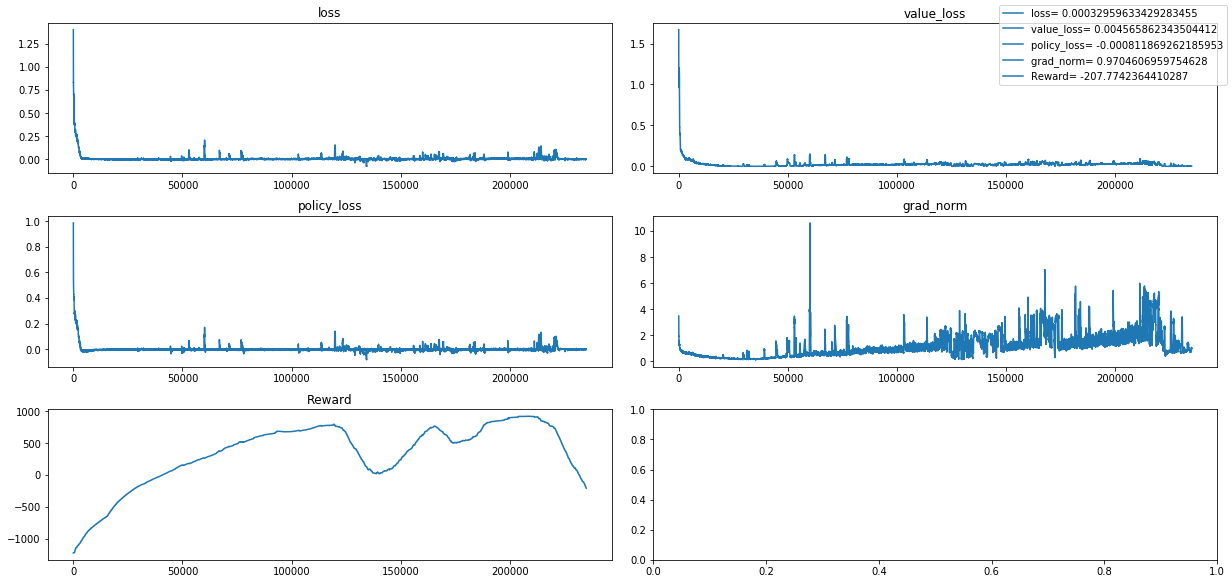

 24%|██▍       | 238388/1000000 [1:11:38<1:18:48, 161.06it/s]

KeyboardInterrupt: 

In [25]:
%%time
curves_names = ['loss', 'value_loss', 'policy_loss', 'grad_norm', 'Reward']
curves = [[], [], [], [], []]

for i in trange(LAST_EPOCH, TOTAL_EPOCH):
    trajectory = sampler.get_next()
    losses = ppo.step(trajectory)
    scheduler.step()
    for j, loss in enumerate(losses):
        curves[j].append(loss)
    mean_reward = env.env.get_values(GAME_NAME + "/reward_mean_100") or [(None, 0)]
    curves[-1].append(mean_reward[-1][1])
    if mean_reward[-1][1] > 1500:
        print("TASK PASSED!")

    if i and i % DROW_STEP == 0:
        clear_output(True)
        fig1, axs = plt.subplots(3, 2, figsize=FIG_SIZE, constrained_layout=True)
        for j, curve in enumerate(curves):
#             axs[j // 2][j % 2].set_ylim(ylims[j])
            axs[j // 2][j % 2].set_title(curves_names[j])
            smoth_curve = moving_average(curve, span=100) if j != 5 else curve
            axs[j // 2][j % 2].plot(smoth_curve, label=f'{curves_names[j]}= {smoth_curve[-1]}')
        fig1.legend()
        plt.show()
    
    if i != LAST_EPOCH and i % SAVE_STEP == 0:
        torch.save(agent, MODEL_MASK.format(last_epoch=i))
